In [1]:
import os
old_cwd = os.getcwd()
os.chdir('..')
new_cwd = os.getcwd()
print('Working directory is changed from {} to {}.'.format(old_cwd, new_cwd))

Working directory is changed from /home/sungjae/Projects/KerasMNIST/results to /home/sungjae/Projects/KerasMNIST.


- Purpose
  1. Import digit images and make them as a dataset.
  2. Run prediction on the dataset.

- To do
  - [X] Change the PNG image recogntion to the recognition of the end image from the NPZ sequence images.

# Import digit images

In [2]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from predict import img2np, get_pad_len
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

w_trgt = h_trgt = 28
d_img_ext = '.npz'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

data_dir = os.path.join(old_cwd, '01-05-11')
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

dir_img_path = os.path.join('..', 'DynamicMNIST-Data', 'data_raster_digit_1000')
img_ext = '.npz'
batch_size = 256 * 4 * 4
model_path = 'cnn.h5'

In [3]:
def get_class_from(filename):
    digit = int(filename.split('_')[-6])
    return digit

def get_pad_params(d_img):
    '''
    PARAMS
    -----
    d_img :  Dynamic image like GIF. A sequence of images.
    - Type : numpy.ndarray. np.float.
    - Shape : (time_steps, w, h)

    RETURNS
    -----
    pad_left, pad_right, pad_top, pad_bottom : int.
    - This function returns the pad length of the four directions.
    '''
    img_last = d_img[-1,:,:]
    h_img = img_last.shape[0]
    w_img = img_last.shape[1]
    sum_along_h = img_last.sum(axis=0) # summation across height
    sum_along_w = img_last.sum(axis=1) # summation across width

    pad_left = get_pad_len(sum_along_h)
    pad_right = get_pad_len(sum_along_h, from_back=True)
    pad_top = get_pad_len(sum_along_w)
    pad_bottom = get_pad_len(sum_along_w, from_back=True)

    return pad_left, pad_right, pad_top, pad_bottom

def crop_square(d_img):
    time_steps = d_img.shape[0]
    h_img = d_img.shape[1]
    w_img = d_img.shape[2]
    pl, pr, pt, pb = get_pad_params(d_img)

    d_img_cropped = d_img[:,pt:h_img-pb,pl:w_img-pr]

    h_img_no_pad = h_img - pt - pb
    w_img_no_pad = w_img - pl - pr

    if h_img_no_pad > w_img_no_pad:
        d_img_new = np.zeros((time_steps, h_img_no_pad, h_img_no_pad))
        pad = h_img_no_pad - w_img_no_pad
        pad_L = pad // 2
        pad_R = pad_L + (pad % 2)
        for t in range(time_steps):
            d_img_new[t,:,:] = np.pad(d_img_cropped[t,:,:],
                ((0,0),(pad_L,pad_R)), mode='constant')
    else:
        d_img_new = np.zeros((time_steps, w_img_no_pad, w_img_no_pad))
        pad = w_img_no_pad - h_img_no_pad
        pad_T = pad // 2
        pad_B = pad_T + (pad % 2)
        for t in range(time_steps):
            d_img_new[t,:,:] = np.pad(d_img_cropped[t,:,:],
                ((pad_T,pad_B),(0,0)), mode='constant')

    return d_img_new

def resize_d_img(d_img, h, w):
    time_steps = d_img.shape[0]
    d_img_new = np.zeros((time_steps, h, w))
    for t in range(time_steps):
        d_img_new[t,:,:] = cv2.resize(
            d_img[t,:,:],
            (h, w), interpolation=cv2.INTER_AREA)

    #_, d_img_new = cv2.threshold(d_img_new,1,255, cv2.THRESH_TOZERO)

    return d_img_new

def resize_and_pad_raster_img(d_img, h, w, pad_width):
    # Depending on the last image, crop the previous images.
    d_img_cropped = crop_square(d_img)
    # Resize sequence images as the model takes.
    d_img_cropped_resized = resize_d_img(d_img_cropped, h-2*pad_width, w-2*pad_width)
    # Add the same pixels of padding around dynamic images.
    d_img_cropped_resized_padded = np.pad(d_img_cropped_resized,
        ((0,0),(pad_width, pad_width),(pad_width, pad_width)),
        mode='constant')

    return d_img_cropped_resized_padded

def split_seq_stack(seq_stack, seq_lengths):
    seqs = list()
    for i, seq_length in enumerate(seq_lengths):
        start = np.sum(seq_lengths[:i], dtype=np.int)
        end = start + seq_lengths[i]
        if end == start:
            print('start, end', (start, end))
        seq = seq_stack[start:end,...]
        seqs.append(seq)
    
    return seqs

In [4]:
d_img_paths = [os.path.join(dir_img_path, f) for f in os.listdir(dir_img_path) if os.path.splitext(f)[-1] == d_img_ext]
d_img_paths = sorted(d_img_paths)
d_img_paths = np.array(d_img_paths)
d_img_names = np.array([os.path.split(d_img_path)[1] for d_img_path in d_img_paths])
npz_paths = d_img_paths
n_total = d_img_paths.shape[0]
#targets = np.array(targets)

In [5]:
img_paths = [os.path.join(dir_img_path, f) for f in os.listdir(dir_img_path) if os.path.splitext(f)[-1] == img_ext]
img_paths = sorted(img_paths)
img_paths = np.array(img_paths)
img_names = [os.path.split(f)[1] for f in img_paths]
img_names = np.array(img_names)
np_img = np.load(img_paths[0])['arr_0']
print(np_img.shape)

(40, 28, 28)


In [6]:
labels = list()
dict_digit_indexes = dict()
for digit in range(10):
    dict_digit_indexes[digit] = list()
for d_img_name in d_img_names:
    label = get_class_from(d_img_name)
    labels.append(label)
    dict_digit_indexes[label] = label
labels = np.array(labels)

In [7]:
model = load_model(model_path)

2022-04-01 15:07:45.625883: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 15:07:46.339635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8698 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5


# Prediction for DMNIST: Cropped data with padding like MNIST

In [8]:
pad_width = 4
'''
rm_pad = True
'''
title = 'result-dmnist-crop-pad-like-mnist'

In [9]:
d_imgs = list()
imgs = list()
d_img_lengths = list()

for d_img_path, label in tqdm(zip(d_img_paths, labels), total=n_total):
    # d_img shape == (time_steps, w, h)
    d_img = np.load(d_img_path)['arr_0']
    
    # Collect sequence lengths for later use.
    d_img_length = d_img.shape[0]
    
    # Set data to collect.
    #d_img = resize_and_pad_raster_img(d_img, h_trgt, w_trgt, pad_width)
    img = d_img[-1,:,:] # Pick the last image.

    d_imgs.append(d_img)
    imgs.append(img)
    d_img_lengths.append(d_img_length)

print(len(d_imgs))
print(len(imgs))
print(len(d_img_lengths))
#dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration=True)
#dataset.batch(batch_size)

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1032.95it/s]

10000
10000
10000


In [10]:
d_imgs = np.array(d_imgs)
imgs = np.array(imgs)
d_img_lengths = np.array(d_img_lengths)

In [11]:
inputs = imgs
targets = labels
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

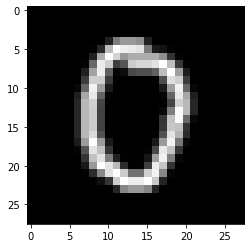

In [12]:
plt.imshow(inputs[0], cmap='gray')

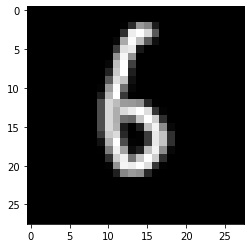

In [13]:
plt.imshow(inputs[18], cmap='gray')

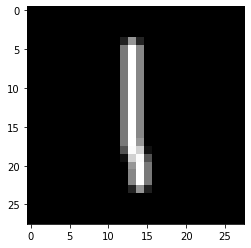

In [14]:
plt.imshow(inputs[2], cmap='gray')

In [15]:
y_pred_all = list()
for x, y in dataset.batch(batch_size):
    y_out = model.predict(x)
    y_pred = np.argmax(y_out, axis=-1)
    y_pred_all += y_pred.tolist()

2022-04-01 15:07:57.511245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


In [16]:
y_trgt = targets
y_pred = y_pred_all

Accuracy  : 1.0
Precision : [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.98]
Recall    : [1.   1.   1.   1.   0.99 1.   1.   0.99 1.   1.  ]
F1-socre  : [1.   1.   1.   1.   0.99 1.   1.   0.99 1.   0.99]
Mean
Precision : 1.0
Recall    : 1.0
F1-socre  : 1.0


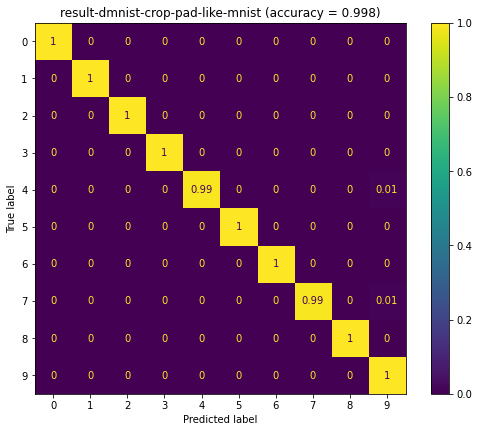

In [17]:
accuracy = accuracy_score(y_trgt, y_pred)
precision, recall, f1score, _ = precision_recall_fscore_support(y_trgt, y_pred, beta=1)

cm = confusion_matrix(y_trgt, y_pred, normalize='true')
cm = np.round(cm,2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
font = {'size' : 10}
plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(8, 6))
plt.tight_layout(pad=2)
plt.title('{} (accuracy = {})'.format(title, round(accuracy,3)))
disp.plot(ax=ax)

plt.savefig(os.path.join(data_dir, '{}.svg'.format(title)))

print('Accuracy  :', np.round(accuracy, 2))
print('Precision :', np.round(precision, 2))
print('Recall    :', np.round(recall, 2))
print('F1-socre  :', np.round(f1score, 2))

print('Mean')
print('Precision :', np.round(precision.mean(), 2))
print('Recall    :', np.round(recall.mean(), 2))
print('F1-socre  :', np.round(f1score.mean(), 2))

## Analyze the results

In [18]:
y_trgt = np.array(y_trgt)
y_pred = np.array(y_pred)
print(y_trgt.shape)
print(y_pred.shape)

(10000,)
(10000,)


In [19]:
dict_correct_indexes = dict()

print('Correct predictions for each digit')
for digit in range(10):
    indexes_digit = np.squeeze(np.argwhere((y_trgt == y_pred) & (y_trgt == digit)), axis=-1)
    dict_correct_indexes[digit] = indexes_digit
    print('Digit {} : {:5d} / {}'.format(digit, len(indexes_digit), len(y_trgt)//10))

Correct predictions for each digit
Digit 0 :  1000 / 1000
Digit 1 :  1000 / 1000
Digit 2 :   998 / 1000
Digit 3 :   999 / 1000
Digit 4 :   991 / 1000
Digit 5 :  1000 / 1000
Digit 6 :  1000 / 1000
Digit 7 :   990 / 1000
Digit 8 :  1000 / 1000
Digit 9 :   999 / 1000


# Importing the dymic images

In [20]:
y_trgt.shape

(10000,)

In [21]:
d_img_lengths.shape

(10000,)

In [22]:
[0] * 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
results = dict()

for digit, digit_indexes in dict_correct_indexes.items():
    print('====================')
    print('#(corret digit {}) = {}'.format(digit, len(digit_indexes)))
    d_targets_correct = list()
    #iterations = 10
    iterations = len(digit_indexes)
    
    d_imgs_correct = d_imgs[digit_indexes]
    d_labels_correct = labels[digit_indexes]
    d_img_lengths_correct = d_img_lengths[digit_indexes]
    for label, length in zip(d_labels_correct, d_img_lengths_correct):
        if length == 0:
            print('length 0!')
        d_targets_correct += [label] * length
    d_targets_correct = np.array(d_targets_correct)
    
    # Stack sequence images into one sequence.
    d_imgs_stack = np.concatenate(d_imgs_correct)
    d_targets = d_targets_correct
    print('d_imgs_stack.shape', d_imgs_stack.shape)
    print('d_targets.shape', d_targets.shape)
    print('d_img_lengths.sum()', d_img_lengths_correct.sum())
    
    
    # Construct tf.Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((d_imgs_stack, d_targets))    
    
    # Evalate for the dataset.
    y_pred_all = list()
    for x, y in dataset.batch(batch_size):
        y_out = model.predict(x)
        y_pred = np.argmax(y_out, axis=-1)
        y_pred_all += y_pred.tolist()
    y_pred_all = np.array(y_pred_all)
    
    print('y_pred_all.shape', y_pred_all.shape)
    
    # Reconstruct the sequences of the flattened dynamic images.
    d_imgs_stack_splitted = split_seq_stack(d_imgs_stack, d_img_lengths_correct)
    d_targets_splitted = split_seq_stack(d_targets, d_img_lengths_correct)
    y_pred_all_splitted = split_seq_stack(y_pred_all, d_img_lengths_correct)
    
    print('len(d_imgs_stack_splitted)', len(d_imgs_stack_splitted))
    print('len(d_targets_splitted)', len(d_targets_splitted))
    print('len(y_pred_all_splitted)', len(y_pred_all_splitted))
    
    results[digit] = dict()
    results[digit]['d_imgs'] = d_imgs_stack_splitted
    results[digit]['y_targets'] = d_targets_splitted
    results[digit]['y_preds'] = y_pred_all_splitted
    

#(corret digit 0) = 1000
d_imgs_stack.shape (25500, 28, 28)
d_targets.shape (25500,)
d_img_lengths.sum() 25500
y_pred_all.shape (25500,)
len(d_imgs_stack_splitted) 1000
len(d_targets_splitted) 1000
len(y_pred_all_splitted) 1000
#(corret digit 1) = 1000
d_imgs_stack.shape (14923, 28, 28)
d_targets.shape (14923,)
d_img_lengths.sum() 14923
y_pred_all.shape (14923,)
len(d_imgs_stack_splitted) 1000
len(d_targets_splitted) 1000
len(y_pred_all_splitted) 1000
#(corret digit 2) = 998
d_imgs_stack.shape (27102, 28, 28)
d_targets.shape (27102,)
d_img_lengths.sum() 27102
y_pred_all.shape (27102,)
len(d_imgs_stack_splitted) 998
len(d_targets_splitted) 998
len(y_pred_all_splitted) 998
#(corret digit 3) = 999
d_imgs_stack.shape (28373, 28, 28)
d_targets.shape (28373,)
d_img_lengths.sum() 28373
y_pred_all.shape (28373,)
len(d_imgs_stack_splitted) 999
len(d_targets_splitted) 999
len(y_pred_all_splitted) 999
#(corret digit 4) = 991
d_imgs_stack.shape (33396, 28, 28)
d_targets.shape (33396,)
d_img_length

In [24]:
def resample(sample_seq, n_sampling_points=100):
    n_samples = len(sample_seq)
    resampled = np.zeros(n_sampling_points)
    for j in range(n_sampling_points):
        i = int(round(j * (n_samples-1) / (n_sampling_points-1)))
        resampled[j] = sample_seq[i]
    return resampled


n_wrong (digit 0) : 0
n_wrong (digit 1) : 0
n_wrong (digit 2) : 0
n_wrong (digit 3) : 0
n_wrong (digit 4) : 0
n_wrong (digit 5) : 0
n_wrong (digit 6) : 0
n_wrong (digit 7) : 0
n_wrong (digit 8) : 0
n_wrong (digit 9) : 0


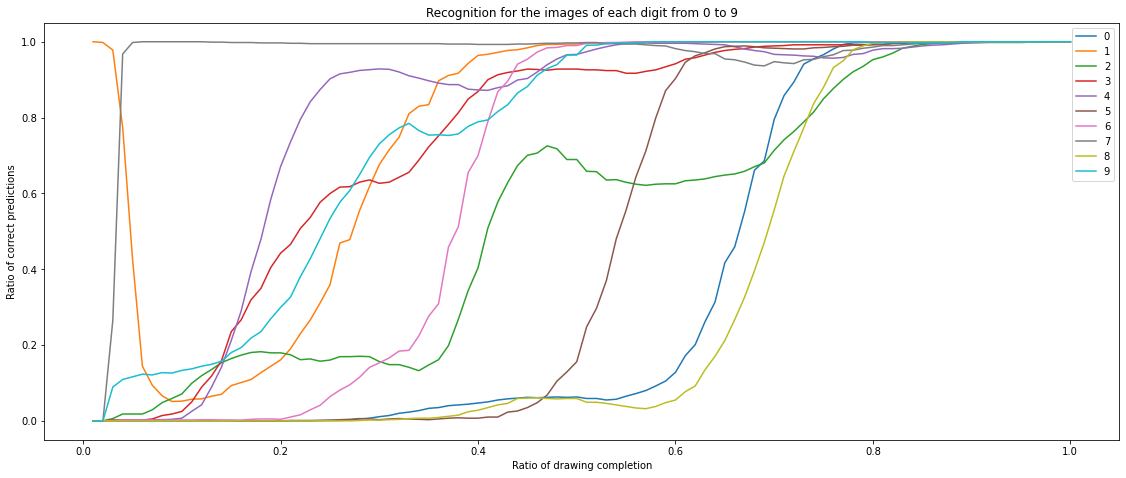

In [25]:
n_sampling_points = 100
x = np.linspace(1.0/n_sampling_points, 1.0, n_sampling_points)

plt.figure(figsize=(16,7))

for digit in range(10):
    d_imgs_digit = results[digit]['d_imgs']
    y_targets_digit = results[digit]['y_targets']
    y_preds_digit = results[digit]['y_preds']
    
    ratio_true = np.zeros(n_sampling_points)
    n_samples = len(y_targets_digit)
    n_wrong = 0
    for i in range(n_samples):
        y_target_resampled = resample(y_targets_digit[i], n_sampling_points)
        y_pred_resampled = resample(y_preds_digit[i], n_sampling_points)
        if y_pred_resampled[-1] != digit:
            n_wrong += 1
            continue
        ratio_true += (y_pred_resampled == digit).astype(np.float)
    ratio_true /= (n_samples - n_wrong)
    print('n_wrong (digit {}) : {}'.format(digit, n_wrong))
    plt.title('Recognition for the images of each digit from 0 to 9'.format(digit))
    plt.xlabel('Ratio of drawing completion')
    plt.ylabel('Ratio of correct predictions')
    plt.plot(x, ratio_true, label=digit)
plt.legend()
plt.tight_layout(pad=2)
plt.savefig(os.path.join(data_dir, 'correct-recognition-ratios.svg'))
plt.show()


n_wrong (digit 0) : 0
n_wrong (digit 1) : 0
n_wrong (digit 2) : 0
n_wrong (digit 3) : 0
n_wrong (digit 4) : 0
n_wrong (digit 5) : 0
n_wrong (digit 6) : 0
n_wrong (digit 7) : 0
n_wrong (digit 8) : 0
n_wrong (digit 9) : 0


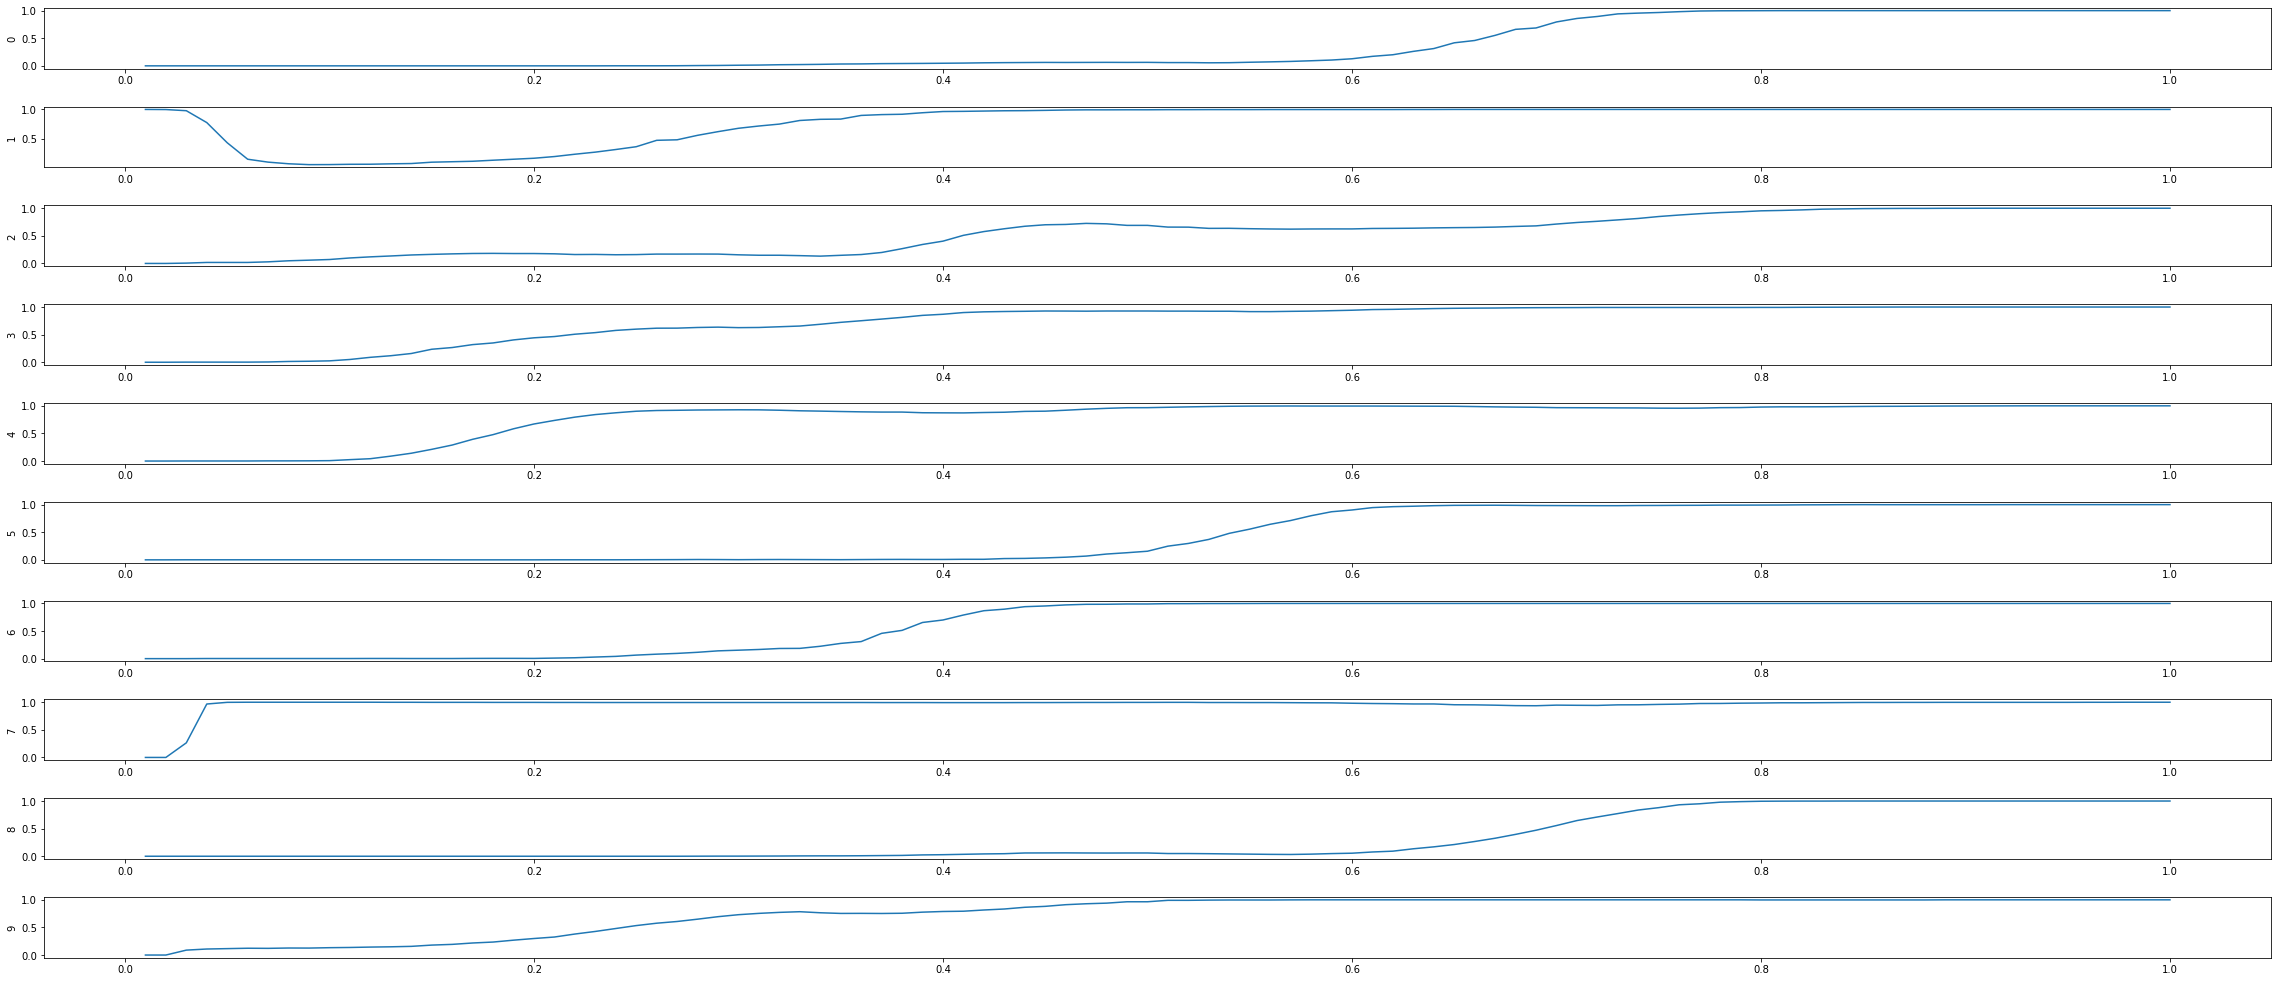

In [26]:
n_sampling_points = 100
x = np.linspace(1.0/n_sampling_points, 1.0, n_sampling_points)

plt.figure(figsize=(32,14))

for digit in range(10):
    d_imgs_digit = results[digit]['d_imgs']
    y_targets_digit = results[digit]['y_targets']
    y_preds_digit = results[digit]['y_preds']
    
    ratio_true = np.zeros(n_sampling_points)
    n_samples = len(y_targets_digit)
    n_wrong = 0
    for i in range(n_samples):
        y_target_resampled = resample(y_targets_digit[i], n_sampling_points)
        y_pred_resampled = resample(y_preds_digit[i], n_sampling_points)
        ratio_true += (y_pred_resampled == digit).astype(np.float)
        if y_pred_resampled[-1] != digit:
            n_wrong += 1
            continue
    ratio_true /= (n_samples - n_wrong)
    print('n_wrong (digit {}) : {}'.format(digit, n_wrong))
    plt.subplot(10, 1, digit+1)
    plt.ylabel(digit)
    plt.plot(x, ratio_true, label=digit)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(data_dir, 'correct-recognition-ratios-subplots.svg'))
plt.show()


n_wrong (digit 0) : 0


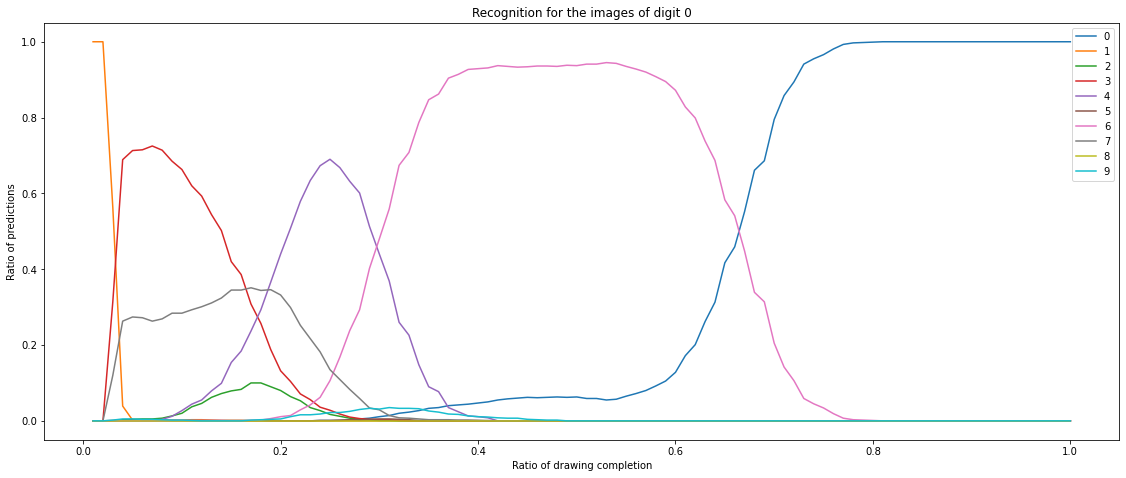

n_wrong (digit 1) : 0


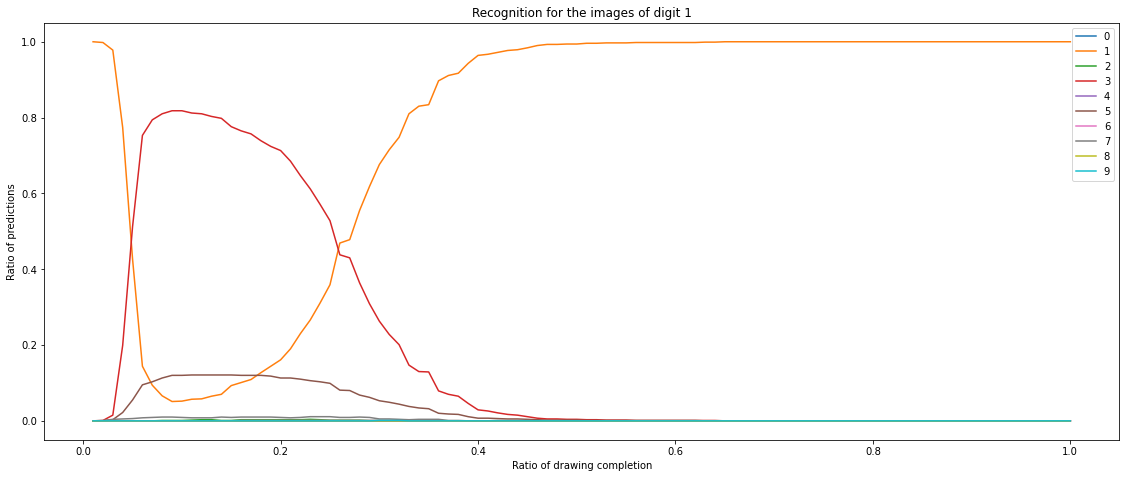

n_wrong (digit 2) : 0


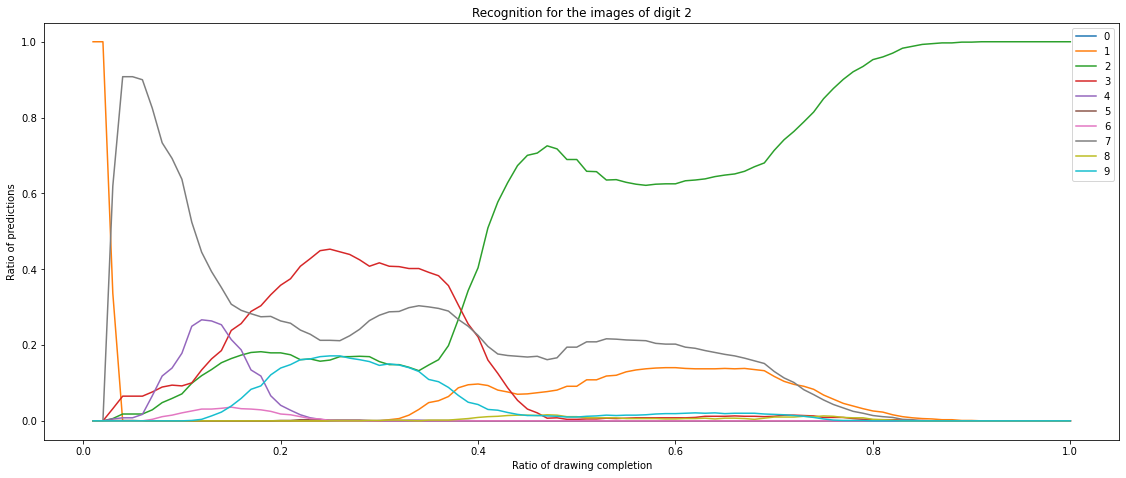

n_wrong (digit 3) : 0


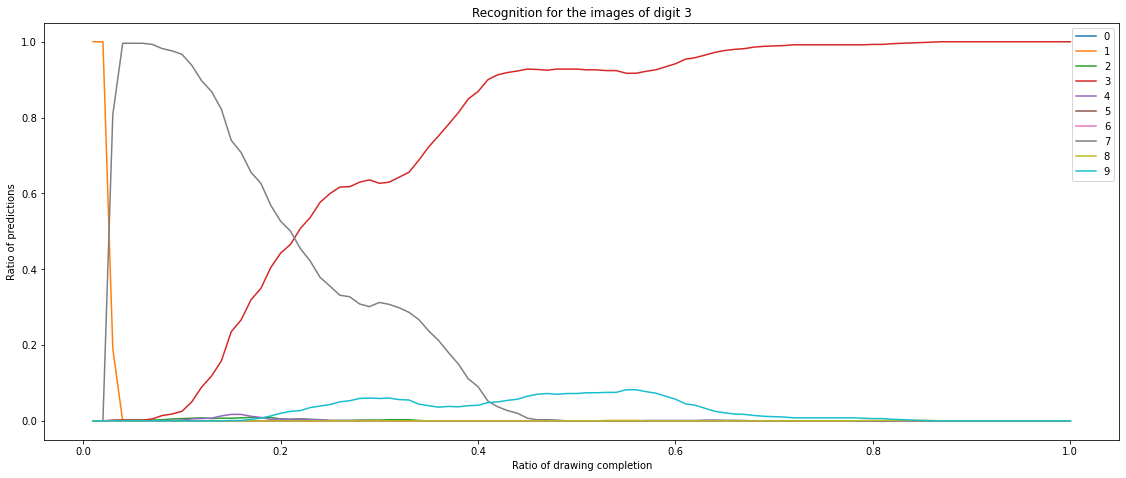

n_wrong (digit 4) : 0


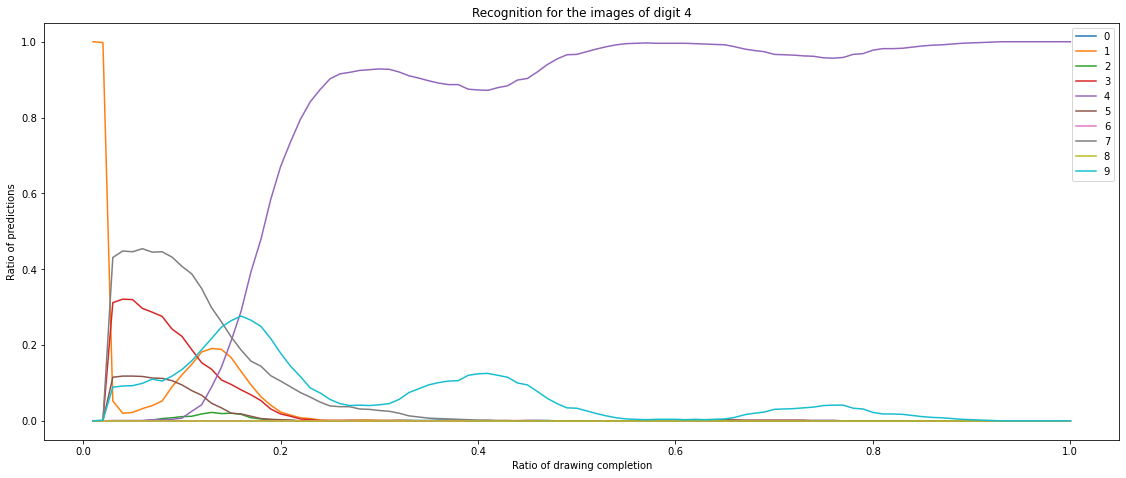

n_wrong (digit 5) : 0


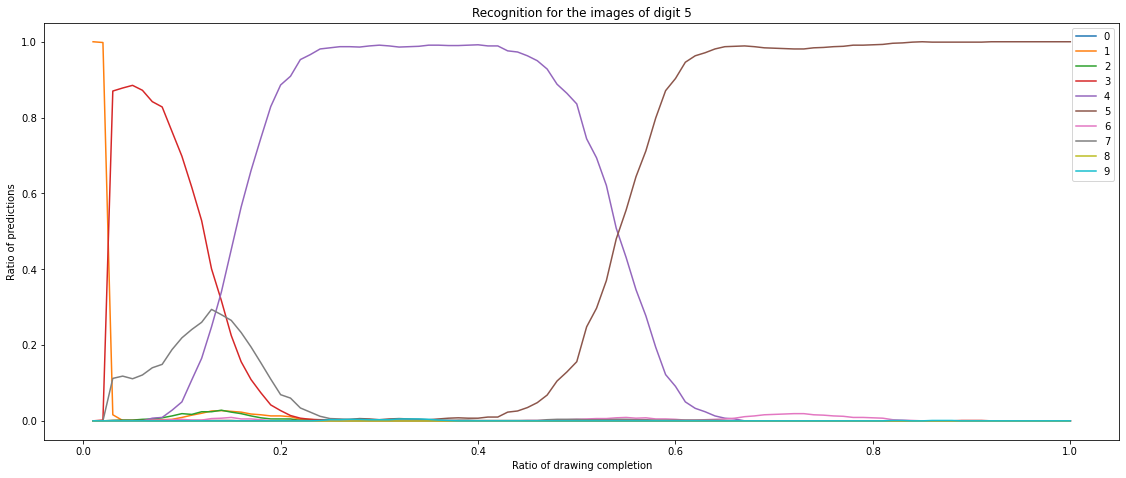

n_wrong (digit 6) : 0


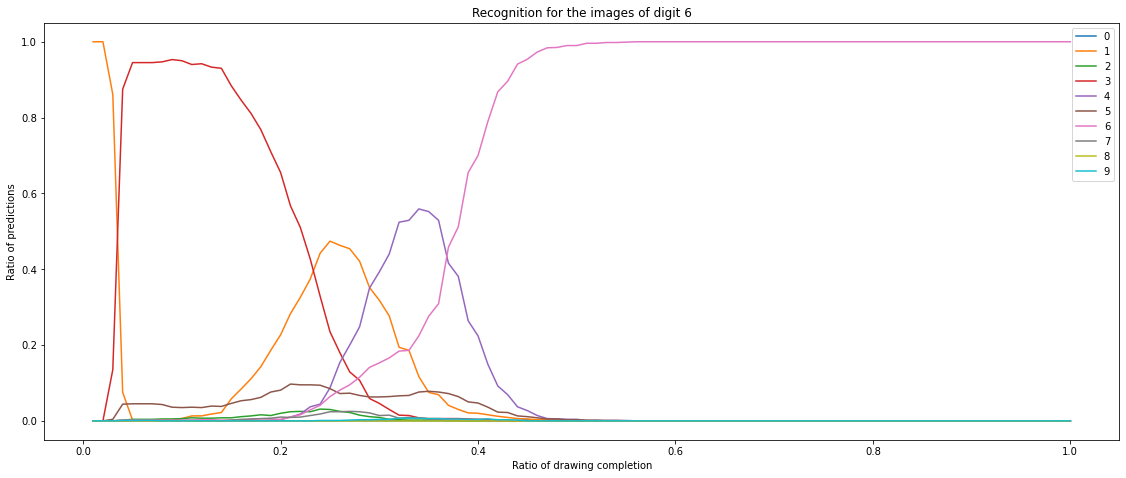

n_wrong (digit 7) : 0


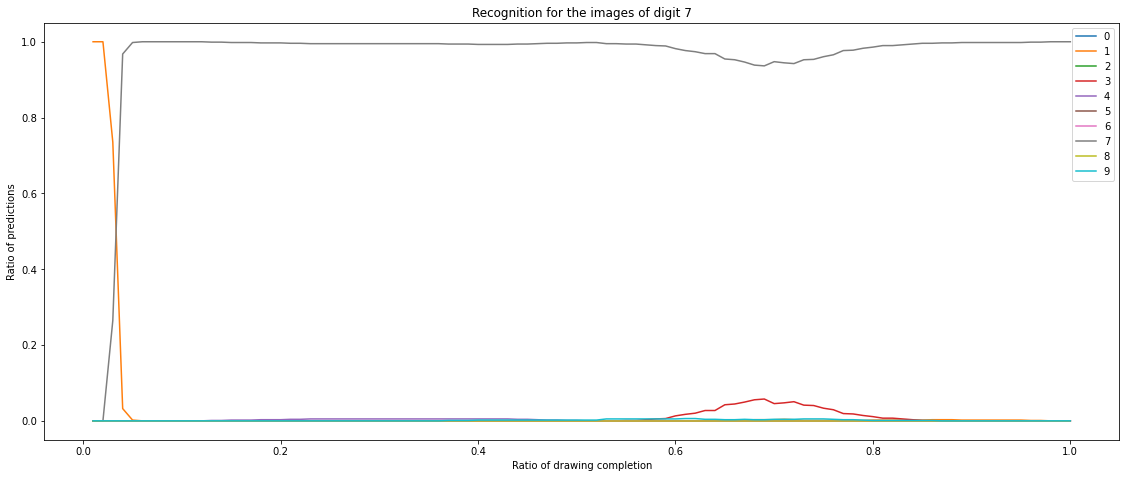

n_wrong (digit 8) : 0


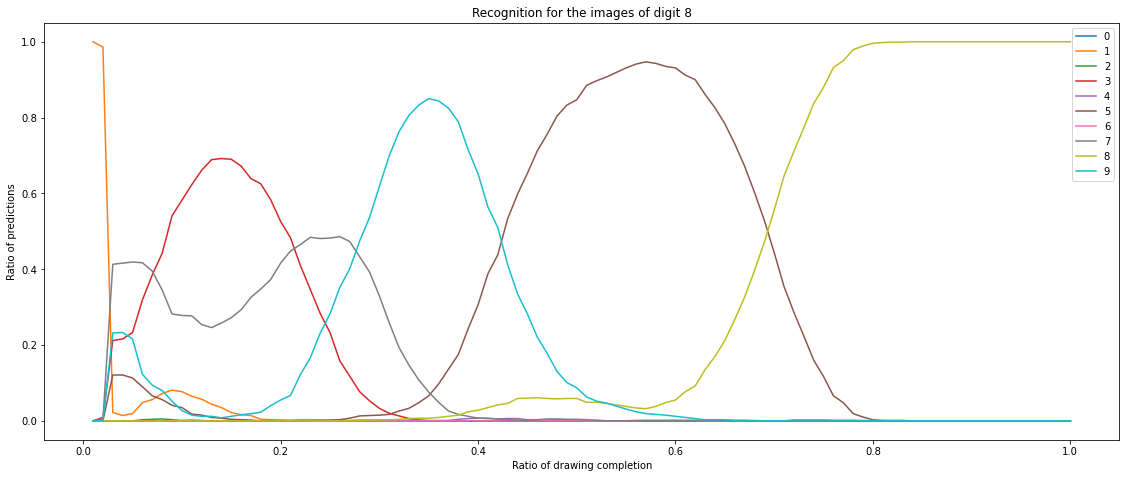

n_wrong (digit 9) : 0


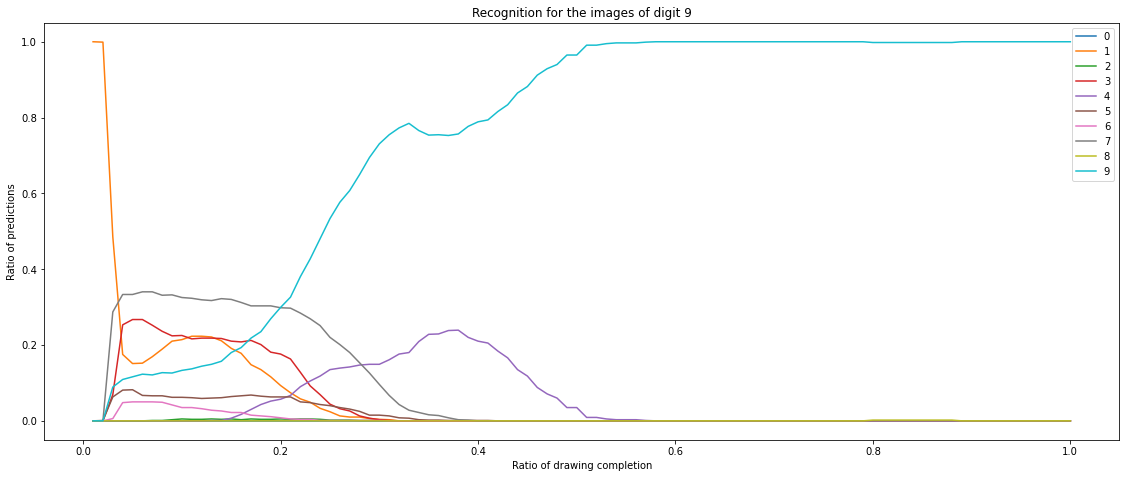

In [27]:
n_sampling_points = 100
x = np.linspace(1.0/n_sampling_points, 1.0, n_sampling_points)

for digit in range(10):
    d_imgs_digit = results[digit]['d_imgs']
    y_targets_digit = results[digit]['y_targets']
    y_preds_digit = results[digit]['y_preds']
    
    
    n_samples = len(y_targets_digit)
    
    plt.figure(figsize=(16,7))
    for digit_subplot in range(10):
        n_wrong = 0
        ratio_true = np.zeros(n_sampling_points)
        for i in range(n_samples):
            y_target_resampled = resample(y_targets_digit[i], n_sampling_points)
            y_pred_resampled = resample(y_preds_digit[i], n_sampling_points)
            if y_pred_resampled[-1] != digit:
                n_wrong += 1
                continue
            ratio_true += (y_pred_resampled == digit_subplot).astype(np.float)
        ratio_true /= (n_samples - n_wrong)
        plt.plot(x, ratio_true, label=digit_subplot)
    print('n_wrong (digit {}) : {}'.format(digit, n_wrong))
    plt.title('Recognition for the images of digit {}'.format(digit))
    plt.xlabel('Ratio of drawing completion')
    plt.ylabel('Ratio of predictions')
    plt.legend()
    
    plt.tight_layout(pad=2)
    plt.savefig(os.path.join(data_dir, 'recognition-ratios-of-each-digit-prediction-for-digit-{}-samples.svg'.format(digit)))
    plt.show()
